# Part 2 | Multi-Factor Investing 
*An Analysis of Fama and French 5 Faktor Model with Momentum (and ESG Factor) on several ETFs on a 10-year time horizon*

In [13]:
import pandas as pd
import numpy as np
import requests
import json
from PIL import Image
from lxml import etree
import sqlite3
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
import warnings
from scipy import stats
from bs4 import BeautifulSoup
import os
import mplfinance as mpf
from datetime import datetime, timedelta
import ipynb.fs.defs.Part1_ESG_Factor_Establishment
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

### Import data

In [14]:
# Importing data of esg scores of each stock we investigate
esg_score_import = pd.read_csv('__data/esg_score.csv', delimiter=",") 

# Importing data of closing prices of each stock we investigate
price_close_import = pd.read_csv('__data/price_close.csv', delimiter=",")

### Selection of portfolios

The portfolios selected for factor analysis encompass a diverse range of investment strategies and market segments:

ESG-Focused Portfolios

1. Best ESG score portfolio
2. Worst ESG score portfolio

Global Market Portfolios

3. VT: Vanguard Total World Stock ETF
4. VEU: Vanguard FTSE All-World ex-US ETF

U.S. Market Segmented Portfolios

5. IVV: iShares Core S&P 500 ETF
6. IJH: iShares Core S&P Mid-Cap ETF
7. IJR: iShares Core S&P Small-Cap ETF

### Establishment of portfolios

ESG-Focused Portfolios

In [15]:
# Function to create portfolio dataframe with stocks, returns, and ESG factor
def create_esg_portfolio(esg_score_data, price_close_returns, percentile, high=True):
    portfolio = getESGScorePercentile(esg_score_data, percentile, high)
    
    returns = []
    esg_factors = []
    
    for date in portfolio.index:
        stock_list = portfolio.loc[date, 'Stock_List']
        
        # Calculate average return for the portfolio
        stock_returns = getPortfolioReturn(price_close_returns, date, stock_list)
        avg_return = stock_returns.mean() if len(stock_returns) > 0 else float('nan')
        
        # Calculate average ESG score for the portfolio
        esg_scores = esg_score_data.loc[date, stock_list]
        avg_esg_score = esg_scores.mean() if len(esg_scores) > 0 else float('nan')
        
        returns.append(avg_return)
        esg_factors.append(avg_esg_score)
    
    portfolio['Return'] = returns
    portfolio['ESG_Factor'] = esg_factors
    
    return portfolio

# Create portfolios with 10% highest and 10% lowest ESG scores
high_esg_portfolio = create_esg_portfolio(esg_score, price_close_returns, 10, high=True)
low_esg_portfolio = create_esg_portfolio(esg_score, price_close_returns, 10, high=False)

# Display the first few rows of each portfolio
print("High ESG Score Portfolio:")
print(high_esg_portfolio.head())
print("\nLow ESG Score Portfolio:")
print(low_esg_portfolio.head())

High ESG Score Portfolio:
                  Stock_List  Stock_Count    Return  ESG_Factor
Date                                                           
2002-01-31                []            0       NaN         NaN
2002-02-28           [SIG.N]            1  0.022727   49.101520
2002-03-31           [SIG.N]            1  0.130889   49.101520
2002-04-30  [SIG.N, ADSK.OQ]            2 -0.107992   45.828962
2002-05-31  [SIG.N, ADSK.OQ]            2 -0.110270   45.828962

Low ESG Score Portfolio:
                Stock_List  Stock_Count    Return  ESG_Factor
Date                                                         
2002-01-31              []            0       NaN         NaN
2002-02-28       [NVDA.OQ]            1 -0.224064   13.966447
2002-03-31         [DXC.N]            1  0.068196    9.257992
2002-04-30  [BFb.N, DXC.N]            2 -0.017859    8.073918
2002-05-31  [BFb.N, DXC.N]            2  0.028666    8.073918


Global Market Portfolios

In [ ]:
def preprocess(asset_name, start_date="2014-11-01", end_date="2024-11-01"):
    # Create 'data' folder if it doesn't exist
    data_folder = '__data'
    os.makedirs(data_folder, exist_ok=True)
    
    # Define the CSV filename
    csv_filename = os.path.join(data_folder, f'{asset_name.lower()}_data.csv')
    
    # Check if the CSV file already exists
    if not os.path.exists(csv_filename):
        # Download the data
        asset_data = yf.download(asset_name, start=start_date, end=end_date)
        # Reset the index to make the date a column
        asset_reset = asset_data.reset_index()
        # Rename the 'Date' column (which is now the first column)
        asset_reset = asset_reset.rename(columns={'Date': 'Date'})
        # Save to CSV file, skipping the first row (header) and without including the index
        asset_reset.to_csv(csv_filename, index=False, header=False)
    
    # Read the CSV file
    df = pd.read_csv(csv_filename, names=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
    
    # Convert the 'Date' column to datetime and set it as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Sort the index in ascending order
    df = df.sort_index()
    
    # Ensure we have the required columns
    required_columns = ['Open', 'High', 'Low', 'Close']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame is missing one or more required columns: {required_columns}")
    
    # Drop any rows with missing data in the required columns
    df = df.dropna(subset=required_columns)
    return df

In [ ]:
# Process each dataset
vt = preprocess("VT")
veu = preprocess("VEU")

U.S. Market Portfolios

In [ ]:
# Process each dataset
ivv = preprocess("IVV")
ijh = preprocess("IJH")
ijr = preprocess("IJR")

### Visualizing data

In [19]:
def plot_last_100(df, title):
    df100 = df.tail(100)
    mpf.plot(df100[['Open', 'High', 'Low', 'Close']], type='candle', style='charles', 
             title=f'Price Movement of {title} (last 100 days)', 
             ylabel='Price', volume=False, figsize=(20, 10), figscale=1.5)
    plt.show()

ESG data

Global Market Portfolios

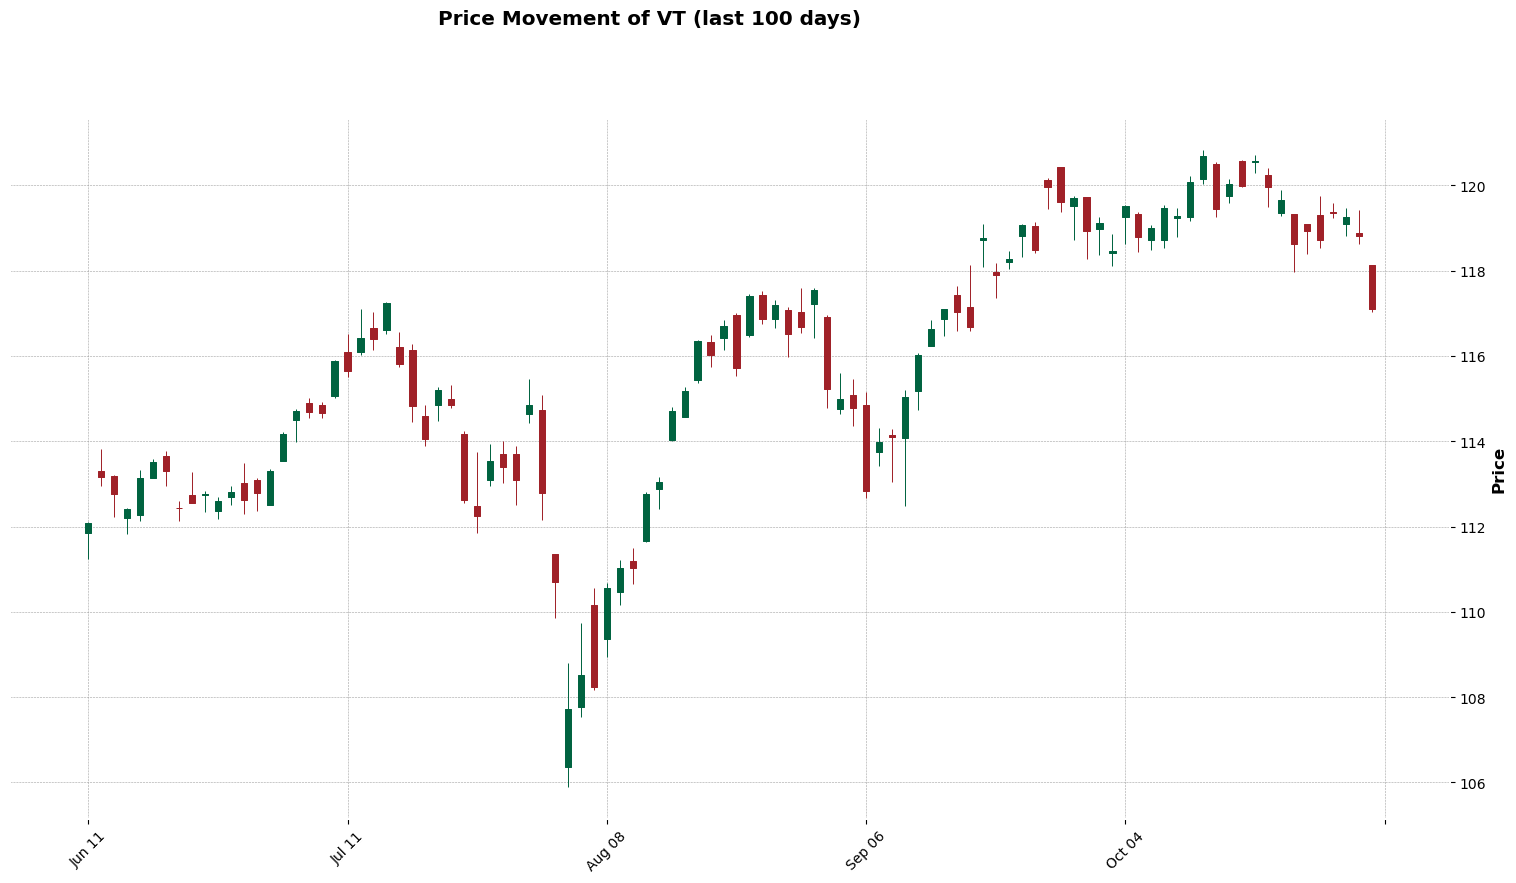

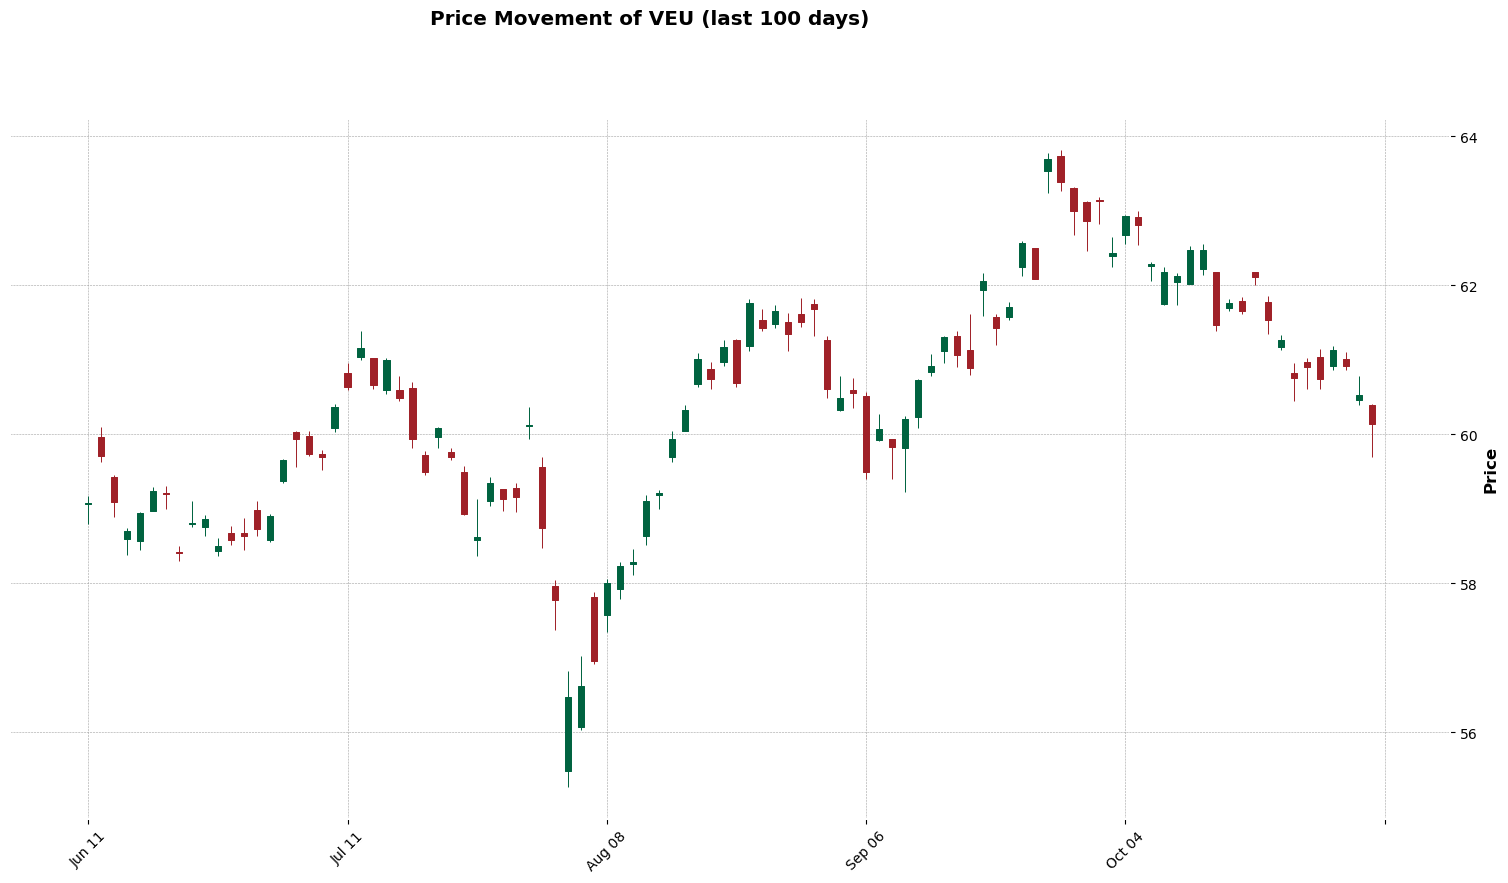

In [20]:
# Plot each dataset
vt_plot = plot_last_100(vt, "VT")
veu_plot = plot_last_100(veu, "VEU")

U.S. Market Portfolios

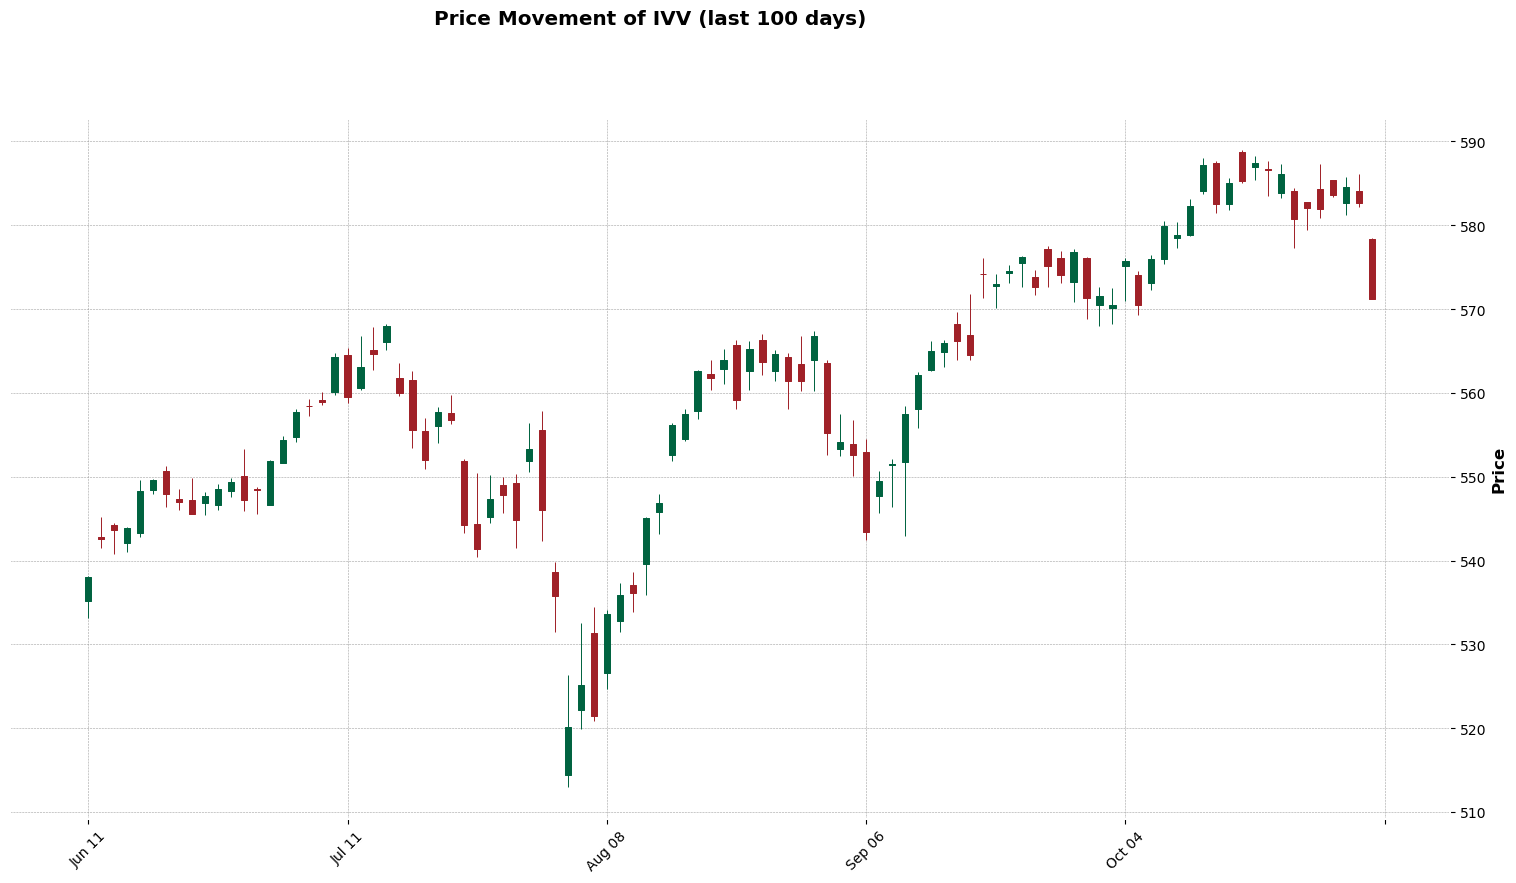

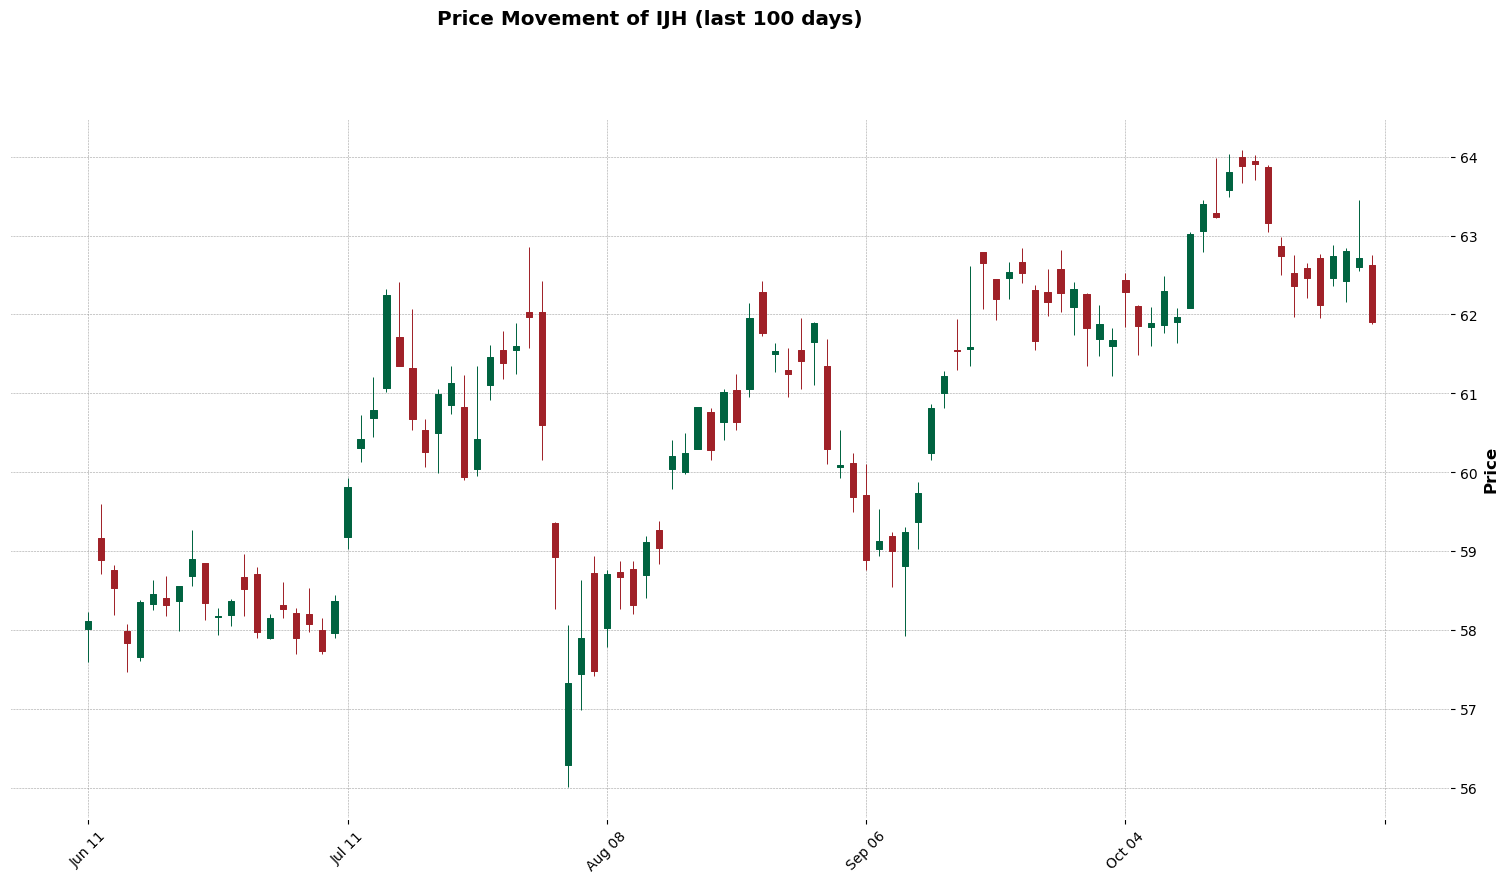

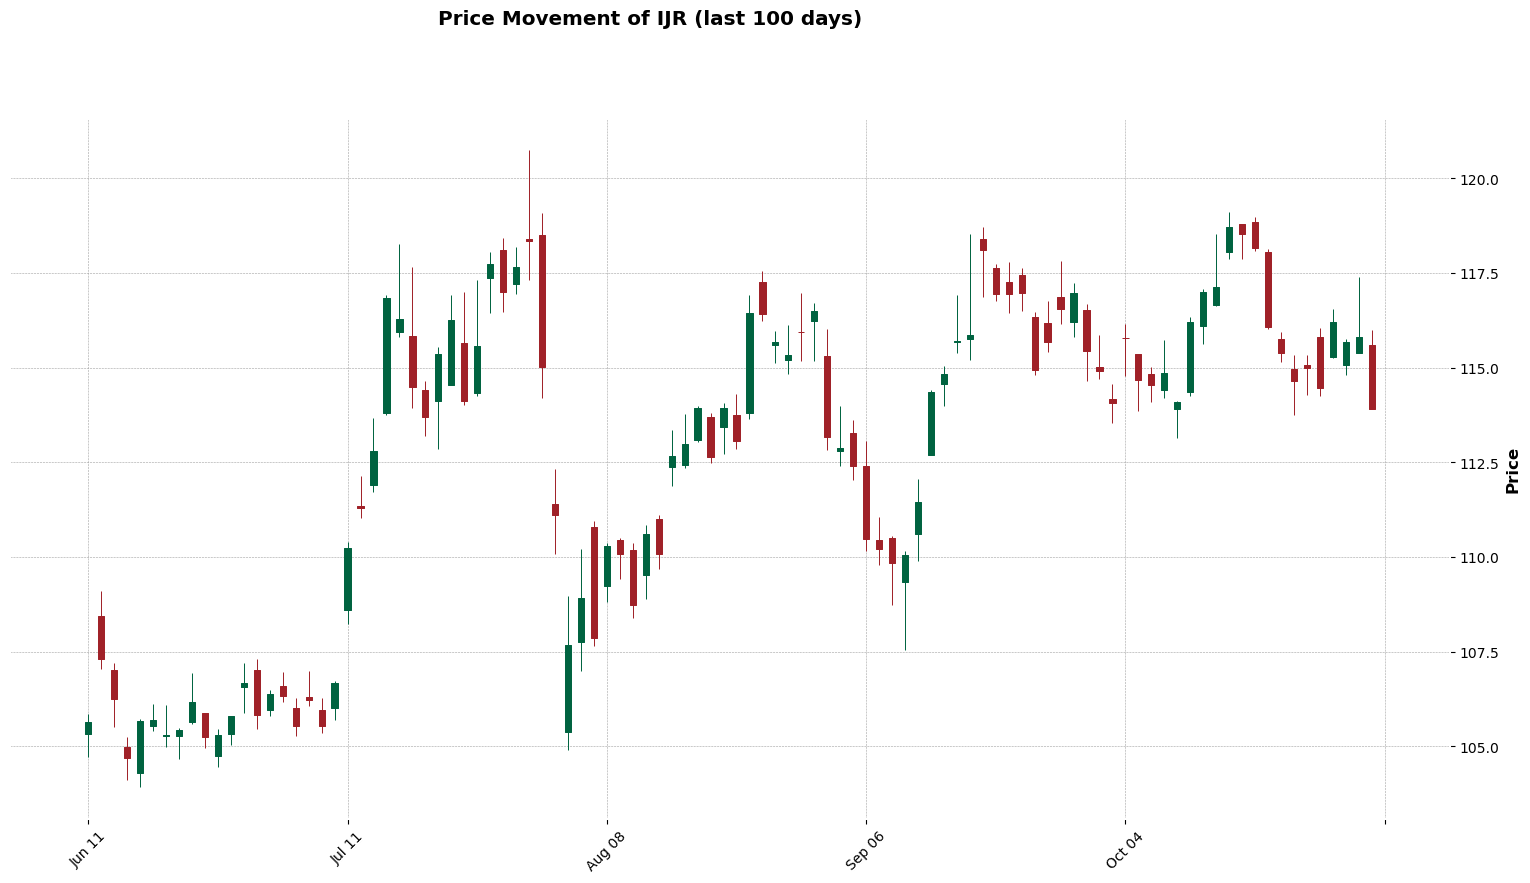

In [21]:
# Plot each dataset
ivv_plot = plot_last_100(ivv, "IVV")
ijh_plot = plot_last_100(ijh, "IJH")
ijr_plot = plot_last_100(ijr, "IJR")

In [ ]:
# Add column names
def add_column_names(df):
    column_names = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df.columns = column_names
    return df

In [ ]:
ivv_df = pd.read_csv("__data/ivv_data.csv")
ivv_df = add_column_names(ivv_df)
ivv_df.head()

In [ ]:
ijh_df = pd.read_csv("__data/ijh_data.csv")
ijh_df = add_column_names(ijh_df)
ijh_df.head()

In [ ]:
ijr_df = pd.read_csv("__data/ijr_data.csv")
ijr_df = add_column_names(ijr_df)
ijr_df.head()

## II. Factor Analysis 

### 1. Data Import and Preprocessing

#### 1.1 Import data

##### 1.2 Fama and French 5-factor data
10-year time window (starting from 2024-10-02)

In [ ]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=2, index_col=0)

# Convert the index to datetime 
ff5.index = pd.to_datetime(ff5.index, format='%Y%m%d')

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')

# Drop observations older than 2009-10-02
ff5 = ff5[ff5.index >= '2014-10-02']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index

# Sort columns
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]     

# Drop index
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
print(ff5.head())

##### 1.3 Tidy and Merge data

In [ ]:
#Merge data
def process_and_rename(df, prefix):
    # Ensure 'Date' is a column, not an index
    if 'Date' not in df.columns:
        df = df.reset_index()
    
    # Rename columns
    rename_dict = {
        'Open': f'open_{prefix}',
        'High': f'high_{prefix}',
        'Low': f'low_{prefix}',
        'Close': f'close_{prefix}'
    }
    df = df.rename(columns=rename_dict)
    
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df[['Date'] + list(rename_dict.values())]

# Process and rename other datasets
ivv = process_and_rename(ivv, 'ivv')
ijh = process_and_rename(ijh, 'ijh')
ijr = process_and_rename(ijr, 'ijr')

# Merge all datasets
data = pd.merge(ivv, ff5, on='Date', how='inner')
data = pd.merge(data, ijh, on='Date', how='inner')
data = pd.merge(data, ijr, on='Date', how='inner')

# Display the first few rows and column names of the resulting dataframe
print(data.head())
print("\nColumns in the merged dataset:")
print(data.columns.tolist())

In [ ]:
#Len data 
len(data)

##### 1.4 Compute Momentum (3, 6 and 12 months) for each ETF

In [ ]:
def calculate_momentum(data, column, lookback, skip=21):
    return data[column].pct_change(lookback).shift(skip)

def add_momentum_factors(data):
    datasets = ['ivv', 'ijh', 'ijr']
    lookbacks = {
        '12m': 252,  # Approximately 252 trading days in a year
        '6m': 126,   # Approximately 126 trading days in 6 months
        '3m': 63     # Approximately 63 trading days in 3 months
    }
    
    for dataset in datasets:
        close_column = f'close_{dataset}'
        for period, lookback in lookbacks.items():
            momentum_column = f'momentum_{period}_{dataset}'
            data[momentum_column] = calculate_momentum(data, close_column, lookback)
            data[momentum_column] = data[momentum_column].fillna(0)
    
    return data

# Apply the function to add momentum factors
data = add_momentum_factors(data)

# Print the first few rows of the dataframe to verify
print(data[['Date'] + [col for col in data.columns if 'momentum' in col]].head(10))

# Print summary statistics of the Momentum columns
print("\nMomentum Summary Statistics:")
for col in data.columns:
    if 'momentum' in col:
        print(f"\n{col}:")
        print(data[col].describe())

# Plot momentum over time for each dataset and period
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle('Momentum over time', fontsize=16)

for i, dataset in enumerate(['ivv', 'ijh', 'ijr']):
    for j, period in enumerate(['12m', '6m', '3m']):
        col = f'momentum_{period}_{dataset}'
        axs[i, j].plot(data['Date'], data[col])
        axs[i, j].set_title(f'{dataset.upper()} - {period} Momentum')
        axs[i, j].set_xlabel('Date')
        axs[i, j].set_ylabel('Momentum')

plt.tight_layout()
plt.show()

In [ ]:
column_names = list(data)
column_names

1.5 Import ESG Factor data

In [ ]:
return_history = pd.read_csv("__data/return_history.csv")
return_history["Date"] = pd.to_datetime(return_history["Date"])
return_history.head()

In [ ]:
data = pd.merge(data, return_history, on='Date', how='inner')
print(data)
print("\nColumns in the merged dataset:")
print(data.columns.tolist())

### 2. Implement the Fama-French 5-Factor Model and Visualize Correlation with Heatmap

ESG Factor integrated

In [ ]:
'''
ESG NEEDS TO BE INTEGRATED
'''

def compute_excess_return_run_regression_and_create_heatmap(data, fund):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()
        
        print(f"\nProcessing {fund.upper()}:")
        print(f"Columns in the dataframe: {df.columns.tolist()}")
        
        # Check if 'Date' column exists
        if 'Date' not in df.columns:
            print("'Date' column is missing. Using the index as the date.")
            df['Date'] = df.index
        
        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - Risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression and correlation
        factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'ESG_Factor'
                   f'momentum_12m_{fund}', f'momentum_6m_{fund}', f'momentum_3m_{fund}',
                   f'Excess_Return_{fund}']

        # Check for NaN values in relevant columns
        nan_count_before = df[factors].isnull().sum().sum()
        df = df.dropna(subset=factors)
        nan_count_after = df[factors].isnull().sum().sum()

        print(f"Rows with NaN values removed: {nan_count_before - nan_count_after}")
        print(f"Remaining observations: {len(df)}")

        # Regression analysis
        X = df[factors[:-1]]  # All factors except Excess_Return
        y = df[f'Excess_Return_{fund}']
        
        X = sm.add_constant(X)  # Add constant term

        # Run OLS regression
        model = sm.OLS(y, X).fit()
        
        print(f"\nRegression results for {fund.upper()} - Fama-French 5-factor model with Momentum:")
        print(model.summary())

        # Create correlation heatmap
        corr_matrix = df[factors].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title(f'Correlation Matrix for {fund.upper()} - Fama-French Factors, Momentum, and Excess Return', fontsize=16)
        plt.tight_layout()
        plt.show()

        print("\nCorrelation Matrix:")
        print(corr_matrix)

        print(f"\nHighly correlated factors for {fund.upper()} (|correlation| > 0.5):")
        for i in range(len(factors)):
            for j in range(i+1, len(factors)):
                if abs(corr_matrix.iloc[i, j]) > 0.5:
                    print(f"{factors[i]} and {factors[j]}: {corr_matrix.iloc[i, j]:.2f}")

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")
        print("DataFrame info:")
        print(df.info())

# Run the computation, regression, and create heatmap for each fund
for fund in ['ivv', 'ijh', 'ijr']:
    compute_excess_return_run_regression_and_create_heatmap(data, fund)

### 3. Data Analysis

##### 3.1 Performance analysis

Risk-adjusted returns

In [ ]:
def calculate_performance_metrics(data, fund):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns for the fund
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - Risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Calculate average daily return and standard deviation of daily returns
        avg_daily_return = df[f'Daily_Return_{fund}'].mean()
        std_daily_return = df[f'Daily_Return_{fund}'].std()
        
        # Calculate annualized metrics
        risk_free_rate = df['RF'].mean() / 100  # Convert to decimal
        annualized_return = (1 + avg_daily_return) ** 252 - 1
        annualized_volatility = std_daily_return * np.sqrt(252)
        
        # Cumulative return
        cumulative_return = (1 + df[f'Daily_Return_{fund}']).cumprod() - 1
        
        # 1. Annualized Return
        print(f"\nPerformance Metrics for {fund.upper()}:")
        print(f"1. Annualized Return: {annualized_return:.4f}")
        
        # 2. Cumulative Return
        print(f"2. Cumulative Return: {cumulative_return.iloc[-1]:.4f}")

        # 3. Annualized Volatility
        print(f"3. Annualized Volatility: {annualized_volatility:.4f}")

        # 4. Sharpe Ratio
        sharpe_ratio = (avg_daily_return - risk_free_rate) / std_daily_return if std_daily_return != 0 else np.nan
        print(f"4. Sharpe Ratio: {sharpe_ratio:.4f}")
        
        # 5. Sortino Ratio (using downside deviation)
        downside_returns = df[f'Daily_Return_{fund}'][df[f'Daily_Return_{fund}'] < 0]
        downside_deviation = np.sqrt((downside_returns**2).mean())
        sortino_ratio = (avg_daily_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan
        print(f"5. Sortino Ratio: {sortino_ratio:.4f}")
        
        # 6. Treynor Ratio (assuming market return is the average of Mkt-RF)
        market_return = df['Mkt-RF'].mean() / 100  # Convert to decimal
        treynor_ratio = (annualized_return - risk_free_rate) / market_return if market_return != 0 else np.nan
        print(f"6. Treynor Ratio: {treynor_ratio:.4f}")
        
        # 7. Alpha using CAPM: α = R_fund - [R_free + β * (R_market - R_free)]
        X = sm.add_constant(df['Mkt-RF'])  # Adding constant for regression
        model = sm.OLS(df[f'Daily_Return_{fund}'], X).fit()
        beta = model.params[1]  # Beta is the slope coefficient for Mkt-RF
        alpha = avg_daily_return - (risk_free_rate + beta * (market_return - risk_free_rate))
        print(f"7. Alpha: {alpha:.4f}")
        
        # 8. Information Ratio: Excess return relative to tracking error
        tracking_error = np.sqrt(((df[f'Excess_Return_{fund}'] - (df['Mkt-RF'])).dropna())**2).mean()
        information_ratio = (avg_daily_return - market_return) / tracking_error if tracking_error != 0 else np.nan
        print(f"8. Information Ratio: {information_ratio:.4f}")
        
        # 9. M2 Measure (Modigliani Measure)
        m2_measure = ((annualized_volatility / std_daily_return) * (annualized_return - risk_free_rate)) + risk_free_rate
        print(f"9. M2 Measure: {m2_measure:.4f}")

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run performance metrics calculation for each fund
for fund in ['ivv', 'ijh', 'ijr']:
    calculate_performance_metrics(data, fund)

Factor-Adjusted Performance

In [ ]:
# Compute Fama-French Alpha for each fund
def calculate_fama_french_alpha(data, fund):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns for the fund
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression
        X = df[['Mkt-RF', 'SMB', 'HML']].dropna()  # Independent variables
        y = df[f'Excess_Return_{fund}'].dropna()   # Dependent variable

        # Align X and y to ensure they have the same index after dropping NaN values
        common_index = X.index.intersection(y.index)
        X = X.loc[common_index]
        y = y.loc[common_index]

        # Add constant term for regression
        X = sm.add_constant(X)

        # Run OLS regression
        model = sm.OLS(y, X).fit()

        # Extract alpha (intercept)
        alpha = model.params['const']
        
        print(f"\nFama-French Alpha for {fund.upper()}: {alpha:.4f}")

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run Fama-French Alpha calculation for each fund
for fund in ['ivv', 'ijh', 'ijr']:
    calculate_fama_french_alpha(data, fund)

##### 3.2 Robustness Check

Time-Varying Factor Exposures

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def rolling_regression(data, fund, window=252):
    try:
        # Create a copy of the data to avoid modifying the original dataframe
        df = data.copy()

        # Ensure Date is in datetime format and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        # Calculate daily returns for the fund
        df[f'Daily_Return_{fund}'] = df[f'close_{fund}'].pct_change()

        # Calculate excess returns: fund returns - risk-free rate
        df[f'Excess_Return_{fund}'] = df[f'Daily_Return_{fund}'] - df['RF'] / 100  # Assuming RF is in percentage

        # Prepare factors for regression
        factors = ['Mkt-RF', 'SMB', 'HML']
        
        # Store results in a DataFrame
        results = pd.DataFrame(index=df.index)

        # Perform rolling regression
        for start in range(len(df) - window):
            end = start + window
            rolling_window_data = df.iloc[start:end]

            # Prepare X and y for regression
            X = rolling_window_data[factors].dropna()
            y = rolling_window_data[f'Excess_Return_{fund}'].dropna()

            # Ensure X and y have matching indices after dropping NaN values
            common_index = X.index.intersection(y.index)
            X = X.loc[common_index]
            y = y.loc[common_index]

            if len(y) > 0:  # Check if there are enough data points for regression
                X_with_const = sm.add_constant(X)
                model = sm.OLS(y, X_with_const).fit()
                results.loc[rolling_window_data.index[-1], 'Alpha'] = model.params['const']
                results.loc[rolling_window_data.index[-1], 'Mkt-RF'] = model.params['Mkt-RF']
                results.loc[rolling_window_data.index[-1], 'SMB'] = model.params['SMB']
                results.loc[rolling_window_data.index[-1], 'HML'] = model.params['HML']

        # Plotting the results of the rolling regression analysis
        plt.figure(figsize=(14, 8))
        plt.subplot(2, 2, 1)
        plt.plot(results['Alpha'], label='Alpha', color='blue')
        plt.title(f'{fund.upper()} - Rolling Alpha')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(results['Mkt-RF'], label='Market Exposure (Mkt-RF)', color='orange')
        plt.title(f'{fund.upper()} - Rolling Market Exposure')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(results['SMB'], label='Size Exposure (SMB)', color='green')
        plt.title(f'{fund.upper()} - Rolling Size Exposure')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(results['HML'], label='Value Exposure (HML)', color='red')
        plt.title(f'{fund.upper()} - Rolling Value Exposure')
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing data for {fund}: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        print(f"Error details: {e.args}")

# Run rolling regression analysis for each fund with a specified window size (e.g., 252 trading days)
for fund in ['ivv', 'ijh', 'ijr']:
    rolling_regression(data, fund, window=252)